In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
df = pd.read_csv('online_gaming_behavior_dataset.csv')
df.head()

PlayerID  Age  Gender Location GameGenre  PlayTimeHours  InGamePurchases  \
0      9000   43    Male    Other  Strategy      16.271119                0   
1      9001   29  Female      USA  Strategy       5.525961                0   
2      9002   22  Female      USA    Sports       8.223755                0   
3      9003   35    Male      USA    Action       5.265351                1   
4      9004   33    Male   Europe    Action      15.531945                0   

  GameDifficulty  SessionsPerWeek  AvgSessionDurationMinutes  PlayerLevel  \
0         Medium                6                        108           79   
1         Medium                5                        144           11   
2           Easy               16                        142           35   
3           Easy                9                         85           57   
4         Medium                2                        131           95   

   AchievementsUnlocked EngagementLevel  
0                    25          Medium  
1                    10          Medium  
2                    41            High  
3                    47          Medium  
4                    37          Medium

### EDA

In [3]:
from ydata_profiling import ProfileReport
report = ProfileReport(df)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Data Preprocessing

In [15]:
df = df.drop(["PlayerID"], axis=1)

In [6]:
# Check missing values
df.isna().sum()

Age                          0
Gender                       0
Location                     0
GameGenre                    0
PlayTimeHours                0
InGamePurchases              0
GameDifficulty               0
SessionsPerWeek              0
AvgSessionDurationMinutes    0
PlayerLevel                  0
AchievementsUnlocked         0
EngagementLevel              0
dtype: int64

### Feature Engineering

In [7]:
categorical_columns = df.select_dtypes(exclude=['int64','float64']).columns
categorical_columns

Index(['Gender', 'Location', 'GameGenre', 'GameDifficulty', 'EngagementLevel'], dtype='object')

In [8]:
# Check the unique values of each categorical column
print(df['Gender'].unique())
print(df['Location'].unique())
print(df['GameGenre'].unique())
print(df['GameDifficulty'].unique())
print(df['EngagementLevel'].unique())

['Male' 'Female']
['Other' 'USA' 'Europe' 'Asia']
['Strategy' 'Sports' 'Action' 'RPG' 'Simulation']
['Medium' 'Easy' 'Hard']
['Medium' 'High' 'Low']


In [16]:
# Encode binary features
df['Gender'] = df['Gender'].map({'Male':1, 'Female':0})

# Encode ordinal features
df['EngagementLevel'] = df['EngagementLevel'].map({'Low':0, 'Medium':1, 'High':2})
df['GameDifficulty'] = df['GameDifficulty'].map({'Easy':0, 'Medium':1, 'Hard':2})

# Encode non-ordinal feature
df = pd.get_dummies(df, columns=['Location'], drop_first=True) 
df = pd.get_dummies(df, columns=['GameGenre'], drop_first=True)
df.head()

Age  Gender  PlayTimeHours  InGamePurchases  GameDifficulty  \
0   43       1      16.271119                0               1   
1   29       0       5.525961                0               1   
2   22       0       8.223755                0               0   
3   35       1       5.265351                1               0   
4   33       1      15.531945                0               1   

   SessionsPerWeek  AvgSessionDurationMinutes  PlayerLevel  \
0                6                        108           79   
1                5                        144           11   
2               16                        142           35   
3                9                         85           57   
4                2                        131           95   

   AchievementsUnlocked  EngagementLevel  Location_Europe  Location_Other  \
0                    25                1            False            True   
1                    10                1            False           False   
2                    41                2            False           False   
3                    47                1            False           False   
4                    37                1             True           False   

   Location_USA  GameGenre_RPG  GameGenre_Simulation  GameGenre_Sports  \
0         False          False                 False             False   
1          True          False                 False             False   
2          True          False                 False              True   
3          True          False                 False             False   
4         False          False                 False             False   

   GameGenre_Strategy  
0                True  
1                True  
2               False  
3               False  
4               False

### Model training

In [18]:
%matplotlib inline

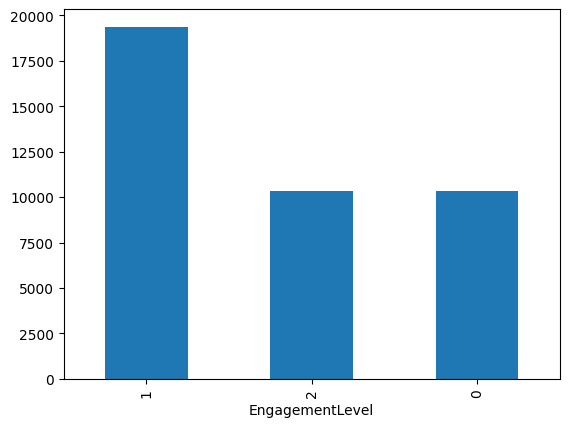

In [ ]:
df['EngagementLevel'].value_counts().plot(kind='bar')
plt.show()

# The imbalance is not severe, so we can proceed without balancing the classes

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap

In [21]:
X = df.drop('EngagementLevel', axis=1)
y = df['EngagementLevel']

# Split the dataset into training and testing sets with stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) 

In [ ]:
# Train XGBoost model
xgb_model = XGBClassifier(objective='multi:softmax', num_class=3)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

# I chose XGBoost because it can handle imbalanced datasets well, and it is known for its high performance

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90      2065
           1       0.91      0.95      0.93      3875
           2       0.93      0.89      0.91      2067

    accuracy                           0.92      8007
   macro avg       0.92      0.91      0.91      8007
weighted avg       0.92      0.92      0.92      8007

Confusion Matrix:
[[1837  175   53]
 [ 108 3679   88]
 [  62  172 1833]]


### Model Interpretation

In [ ]:
# print(X_train.dtypes)
X_train = X_train.astype(float)  # Convert everything to float to avoid errors for SHAP
X_test = X_test.astype(float)

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions

In [ ]:
# Explain the model using SHAP
explainer = shap.Explainer(xgb_model, X_train)  # Tree-based SHAP explainer for XGBoost
shap_values = explainer(X_test)  # Compute SHAP values for test data

100%|===================| 24005/24021 [02:20<00:00]        

In [35]:
shap_values.shape

(8007, 16, 3)

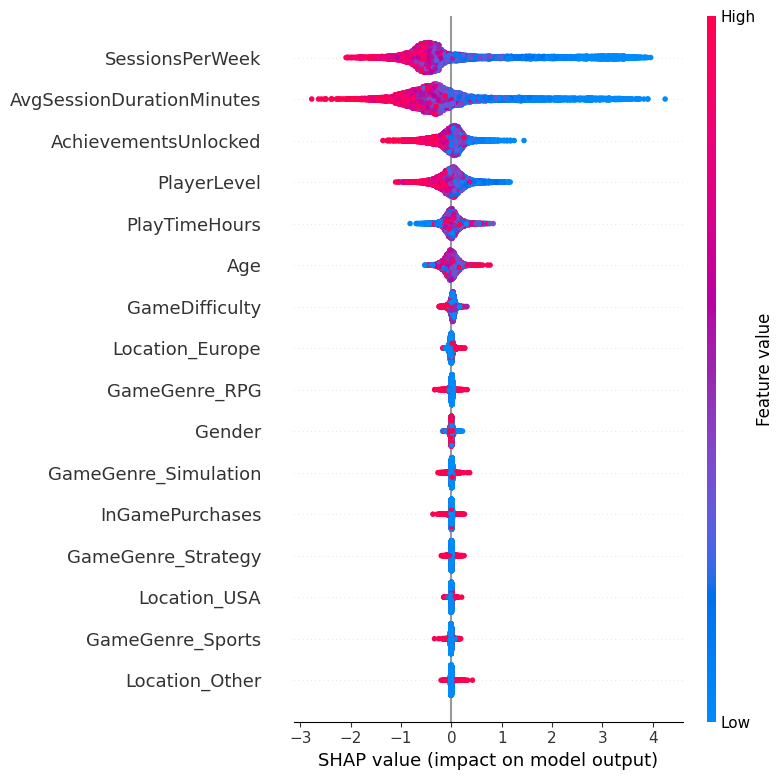

In [ ]:
# Summary plot of class 0: Low engagement
shap.summary_plot(shap_values[:, :, 0], X_test)

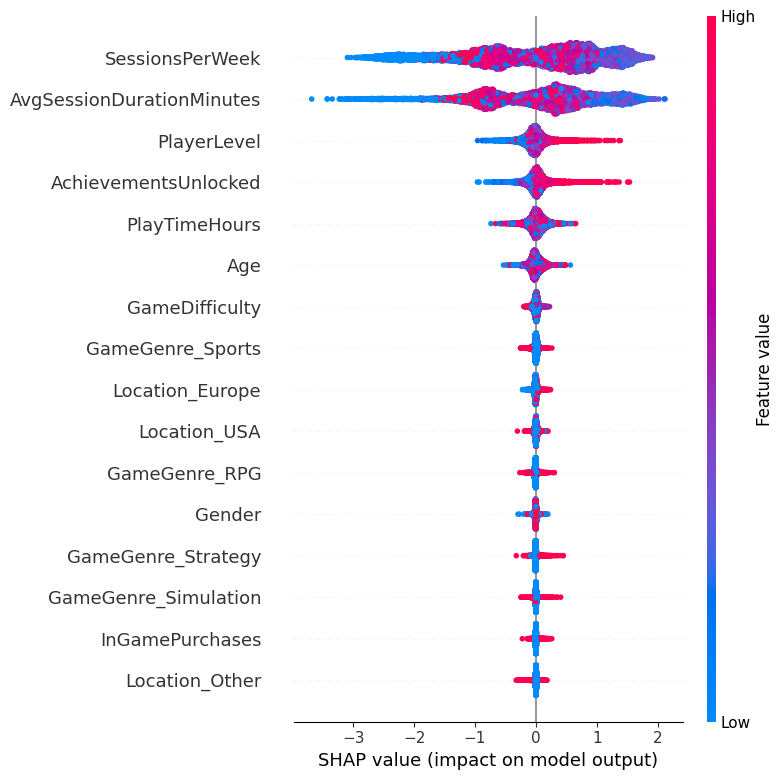

In [37]:
# Summary plot of class 1: Medium engagement
shap.summary_plot(shap_values[:, :, 1], X_test)

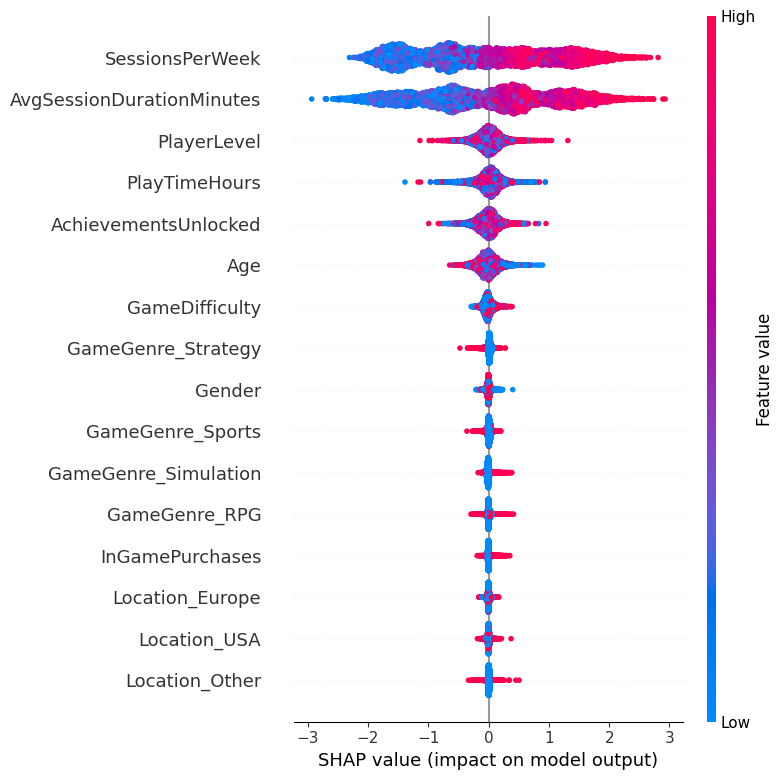

In [38]:
# Summary plot of class 2: High engagement
shap.summary_plot(shap_values[:, :, 2], X_test)

### **SHAP Analysis for Player Retention Prediction**

##### **1. Key Features Influencing Player Retention**
From the three SHAP plots corresponding to different engagement levels, the following features have the highest impact on player retention:

- **SessionsPerWeek**  
  - The most **influential factor** in determining retention.  
  - Players with **higher session frequency** tend to have **higher engagement**.
  - Lower values (blue) contribute more to *low engagement*, while higher values (red) contribute positively to *high engagement*.

- **AvgSessionDurationMinutes**  
  - Longer play sessions **increase engagement**.  
  - Players with **short session durations tend to churn**, while those who play longer per session show positive retention.

- **PlayerLevel**  
  - Higher levels correlate with increased engagement.
  - **Lower-level players** (blue) are more likely to disengage.

- **AchievementsUnlocked**  
  - Unlocking achievements **helps retain players**, but the impact is less significant than session frequency and duration.

- **PlayTimeHours**  
  - Higher total playtime contributes to retention, but **its impact is weaker compared to session-based metrics**.

---

##### **2. Medium Impact Features**
- **Age**  
  - Younger players show **slightly higher engagement**, but age does not have a dominant impact.

- **GameDifficulty**  
  - Players may **drop out** if the game is too difficult or too easy.
  - A **balanced difficulty level** might help retention.

- **GameGenre (RPG, Sports, Simulation, Strategy, etc.)**  
  - No single game genre overwhelmingly determines retention, though **RPG and Simulation** games show some positive correlation.

- **Location (Europe, USA, Other)**  
  - Geographic differences exist but have a **lower impact compared to session-based metrics**.

- **Gender**  
  - Gender has a **minimal effect on retention**.

- **InGamePurchases**  
  - Surprisingly, **monetary investment does not strongly correlate with engagement**.

---

##### **3. Differences Across Engagement Levels**
- For Low and High engagement, **SessionsPerWeek** seems to play a determining role in classification (ie, almost no players with large values of **SessionsPerWeek** is classified Low engagement, vice versa)
- **AchievementsUnlocked** is more important and Low and Medium engagement, I support the reason is player with High Engagement are not left with many achievements unlocked to make a difference. 

---
##### **4. Business Implications & Recommendations**
Based on the SHAP analysis, the **best strategies to improve player retention** include:

**1. Encouraging More Frequent Sessions**
- Implement **daily login rewards** or **progressive streak bonuses**.
- Introduce **weekly challenges** to encourage consistent gameplay.
- **Push Notifications & Email Reminders**: Remind inactive players of rewards, upcoming events, or unfinished tasks to bring them back.

**2. Optimizing Session Duration**
- **Immersive Game Loops**: Implement engaging mechanics like progressive rewards (e.g., unlocking bonuses the longer they play in a session).
- **Content Expansion**: Keep players engaged with procedural content, live events, or story-driven experiences.
- **Time-Based Power-Ups**: Offer increasing bonuses the longer players stay in a session (e.g., increasing XP multipliers).

**3. Helping Players Advance Levels Faster**
- Players who struggle to progress may churn.
- Introduce **early-game boosters** or **guidance features** to help new players level up.
- **“Catch-Up” Mechanics**: Allow inactive players to earn boosted XP or bonus items when they return.

**4. Enhancing Achievement-Based Engagement**
- **Dynamic Achievement Tracking:** Provide real-time notifications when players are close to unlocking an achievement.

**5. Adjusting Game Difficulty**
- Allow **customizable difficulty settings** to cater to different player preferences.
- Balance progression to **keep challenges engaging without being frustrating**.

**6. Tailoring Strategies by Region**
- Since **location has some impact**, consider **region-specific promotions and localized events**.

**7. Rethinking Monetization Approaches**
- **In-game purchases do not significantly impact retention**.
- Instead, focus on **cosmetic or experience-enhancing purchases** that **reward engaged players**.

